**NOTE:** This is a notebook supporting a blog post. More than likely I will not just convert the notebook into markdown and publish. Instead, I'll likely be selective with what code I show in the blogpost _and_ I'll likely upload manually annotated graphviz plots for the final post.

# Level up your Bayesian an Causal Inference workflow in PyMC: Introducing the new `observe` and `do` functions

We've got some exciting experimental new functionality coming to PyMC which helps users do graph manipulation. If you don't know what that is, then you will soon! But know that this will be particularly useful in both Bayesian and Causal inference workflows.

This post is going to cover a lot of ground, so strap in. Readers of this post are going to learn:
* That PyMC models are represented behind the scenes as Bayesian DAGS
* That PyMC models can be considered as implementing Bayesian versions of Pearl's Structureal Causal Models
* That we can manipulate these graphs in a variety of ways for fun and profit
* When we do out-of-sample prediction we are doing graph manipulation. This was already achieveable with `pm.sample`, but now we can use the new `do` operator.
* Thanks to the new `observe` and `do` functions, we can expand our PyMC modelling workflow by:
  1. Defining the full data generating process in the absence of any data
  2. Perform graph manipulation by injecting _parameter values_ with the new `observe` function. This is useful as you can sample from this new model to generate simulated datasets.
  3. Again perform graph manipulation by injecting _data_ (using `observe`) to obtain a new model which we can use to infer posterior distributions over latent parameters given the data.
  4. We can also perform graph manipulation with the `do` operator, but this time to calculate counterfactuals.
  
**NOTE:** The functionality we talk about in this post, specifically the `do` and `observe` functions rely on some experimental code. Therefore these functions exist in the suitably named [`pymc-experimental`](https://github.com/pymc-devs/pymc-experimental) repo.

Setup an environment as follows. Note that the `"libblas=*=*accelerate"` should only be included when working on an Apple Silicon machine.

```bash
mamba create -n do_operator python=3.11 pymc-base "libblas=*=*accelerate" matplotlib numpy pandas seaborn scipy jupyterlab ipykernel python-graphviz
mamba activate do_operator
python -m ipykernel install --user --name do_operator
pip install git+https://github.com/pymc-devs/pymc-experimental.git
pip install daft
```

In [1]:
import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_experimental as pmx
import seaborn as sns
from packaging import version

In [2]:
# check we have the required versions
assert version.parse(pm.__version__) >= version.parse('5.4.1')
assert version.parse(pmx.__version__) >= version.parse('0.0.5')

In [3]:
# import the new functionality
from pymc_experimental.model_transform.conditioning import do, observe

In [4]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [10, 6]
SEED = 1234
rng = np.random.default_rng(SEED)

Conducting Bayesian inference using MCMC methods in the current era has two key requirements. MCMC sampling algorithms need a) a log probability density for any given set of latent parameters and data, b) gradient information about that log probability density.

However, an optional component of probabilistic programming libraries would be to have a (behind the scenes) representation of the graph structure of any given model. PyMC is one of those libraries!

When you build your PyMC model, it constructs a symbolic graph representation of the model. We can think of this perhaps as similar to your own internal mental model of what nodes influence what other nodes in a data generating process.

Having this form of representation is powerful because it allows various graph manipulations to take place. One promising use case for this is automagical graph transformations - here PyMC could analyse a model and simplify it, by looking for conjugate priors for example. Another use case is explicit user-driven modification of the graph.

To understand what we mean by this, let's consider some routine functionality that has been in PyMC for some time now, that of out of sample posterior prediction.

## Example 1 - Graph manipulation for out-of-sample posterior prediction
Let's take a univariate regression problem as an example. A typical (but not complete) Bayesian workflow would consist of the following stages:
* Build a linear regression model in PyMC with our observed data stored as `MutableData` nodes.
* Run inference on the unknown coefficients with `pm.sample`
* Run out-of-sample prediction by updating the observed predictor values (`MutableData` nodes) with new values.

This last step is an example of graph manipulation where a user dives in and changes the values of a `MutableData` node with new values. This was already achievable with `pm.set_data`, and there are plenty of example notebooks demonstrating this on the [PyMC Examples gallery](https://www.pymc.io/projects/examples/en/latest/gallery.html) section of the website.

But let's see this workflow in action with the new `do` operator functionality

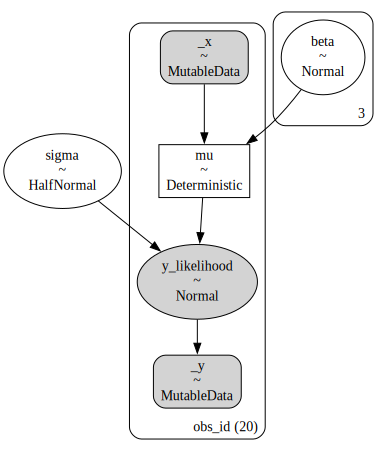

In [5]:
# 1. Simulate data
N = 20
x = np.random.normal(0, 1, N)
y = -2 + 0.5 * x + -0.8 * x**2 + np.random.normal(0, 0.2, N)
df = pd.DataFrame({"x": x, "y": y})

# 2. Build a PyMC model
with pm.Model(coords_mutable={"obs_id": np.arange(N)}) as model:
    _x = pm.MutableData('_x', df['x'], dims="obs_id")
    _y = pm.MutableData('_y', df['y'], dims="obs_id")
    beta = pm.Normal('beta', shape=3)
    sigma = pm.HalfNormal('sigma')
    mu = pm.Deterministic("mu", beta[0] + beta[1] * _x + beta[2] * _x**2, dims="obs_id")
    pm.Normal('y_likelihood', mu=mu, sigma=sigma, observed=_y, dims="obs_id")
    
pm.model_to_graphviz(model)

In [6]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


### Graph manipulation for out of sample prediction - the old way

In [7]:
# 3. Out of sample posterior prediction - the old way
NI = 100
xi = np.linspace(np.min(x), np.max(x), NI)
yi = np.full(NI, np.nan)
     
with model:
    pm.set_data({'_x': xi, '_y': yi}, coords={"obs_id": np.arange(NI)})
    idata.extend(pm.sample_posterior_predictive(idata, var_names=["mu"]))

Sampling: []


What we've done here is to manipulate the graph by injecting new data into the $x$ and $y$ `MutableData` nodes. If we visualise the model, we can see this as the label in the plate now shows that we have 100 instances of these variables in the graph.

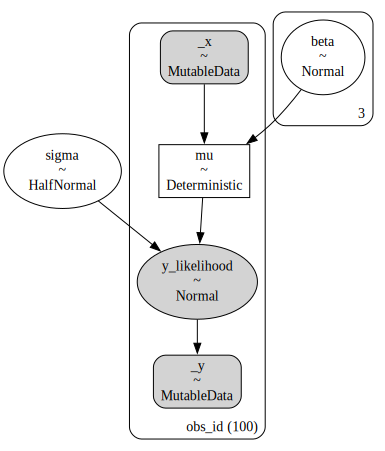

In [8]:
pm.model_to_graphviz(model)

### Graph manipulation for out of sample prediction - the new way

So let's introduce the `do` operator. This function allows you to do graph manipulation in the same way that we achieved with `pm.set_data`. Though if you read on further you'll see that this is just the tip of the iceberg.

In [9]:
model_pred = do(model, {'_x': xi, '_y': yi})

with model_pred:
    idata_pred = pm.sample_posterior_predictive(idata, var_names=["mu"])

Sampling: []


Checking the updated graph shows the same graph manipulation has taken place.

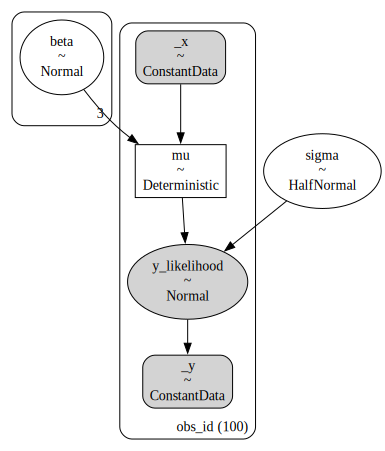

In [10]:
pm.model_to_graphviz(model_pred)

Just to convince you that these do the same operations, here's a plot of the out of sample predictions using both methods

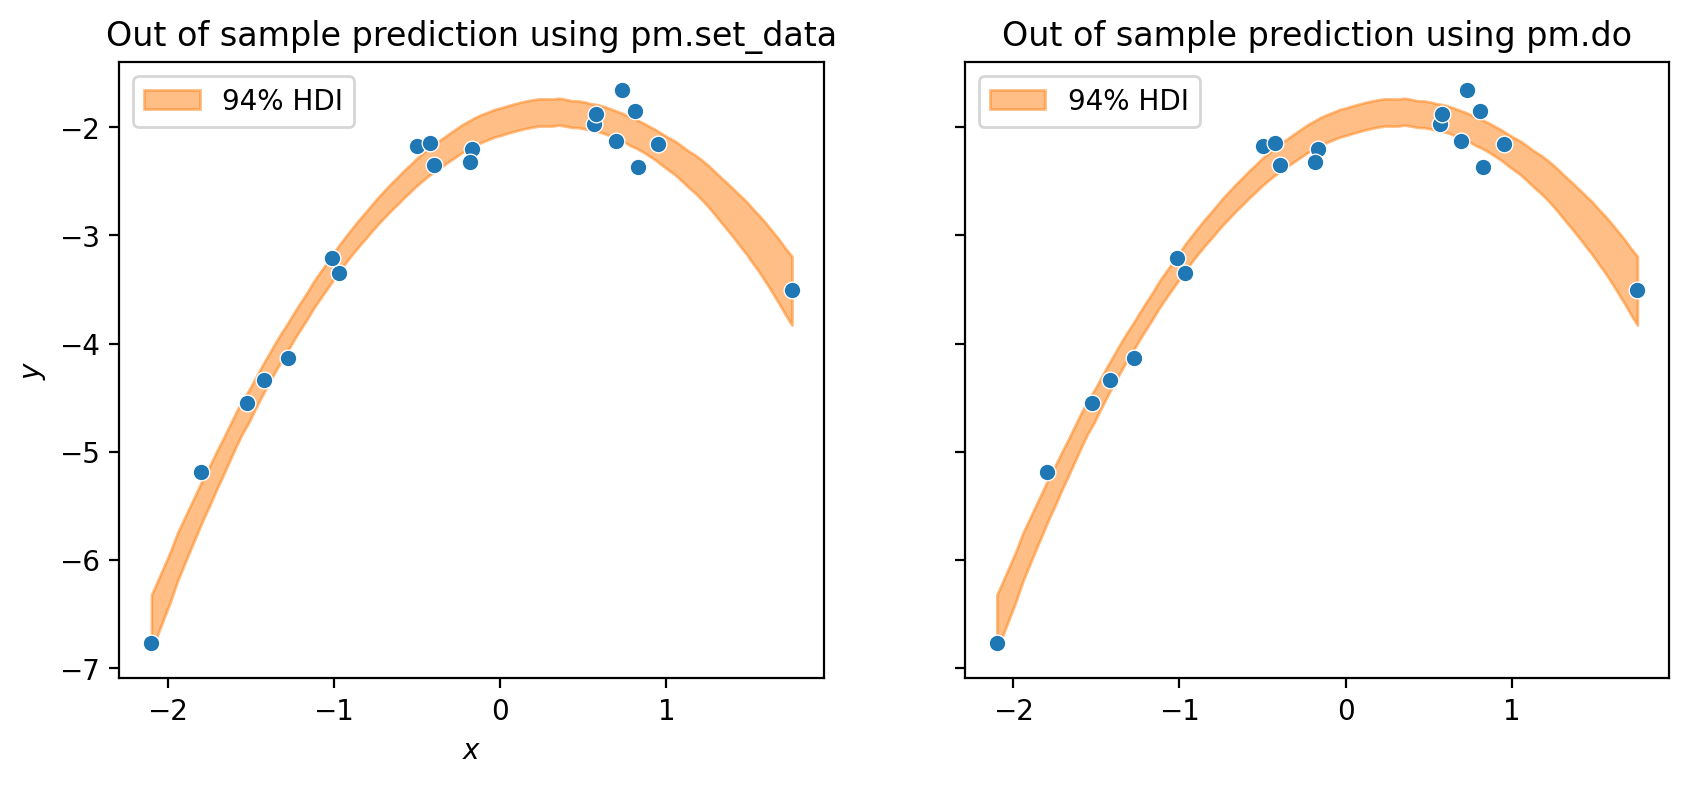

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

az.plot_hdi(xi, idata.posterior_predictive['mu'], smooth=False, ax=ax[0], fill_kwargs={"label": "94% HDI"})
sns.scatterplot(df, x=x, y=y, ax=ax[0])
ax[0].set(title="Out of sample prediction using pm.set_data", xlabel=r"$x$", ylabel=r"$y$")
ax[0].legend()

az.plot_hdi(xi, idata_pred.posterior_predictive['mu'], smooth=False, ax=ax[1], fill_kwargs={"label": "94% HDI"})
sns.scatterplot(df, x=x, y=y, ax=ax[1])
ax[1].set(title="Out of sample prediction using pm.do")
ax[1].legend();

This example has introduced the concept of graph manipulation in an already commonly used situation, out of sample posterior prediction.

So far we've only seen that we can use the `do` operator to inject new data into `MutableData` nodes. But let's take this to 11 and see what we can do ;)

## Example 2 - Taking your Bayesian causal inference workflow to the next level - graph manipulation with `observe` and `do`.

### The example we'll work with

In this post, we'll be working with an idiomatic causal DAG where we have a binary treatment variable $Z$ which may or may not causally influence an outcome $Y$. However, this relationship suffers from confounding by $C$ which causally influences both treatment and outcome.

Further, we turn this into a Bayesian causal DAG by specifying probabilistic causal relationships between the nodes. A prior is placed on $C$ as it has no parent nodes.

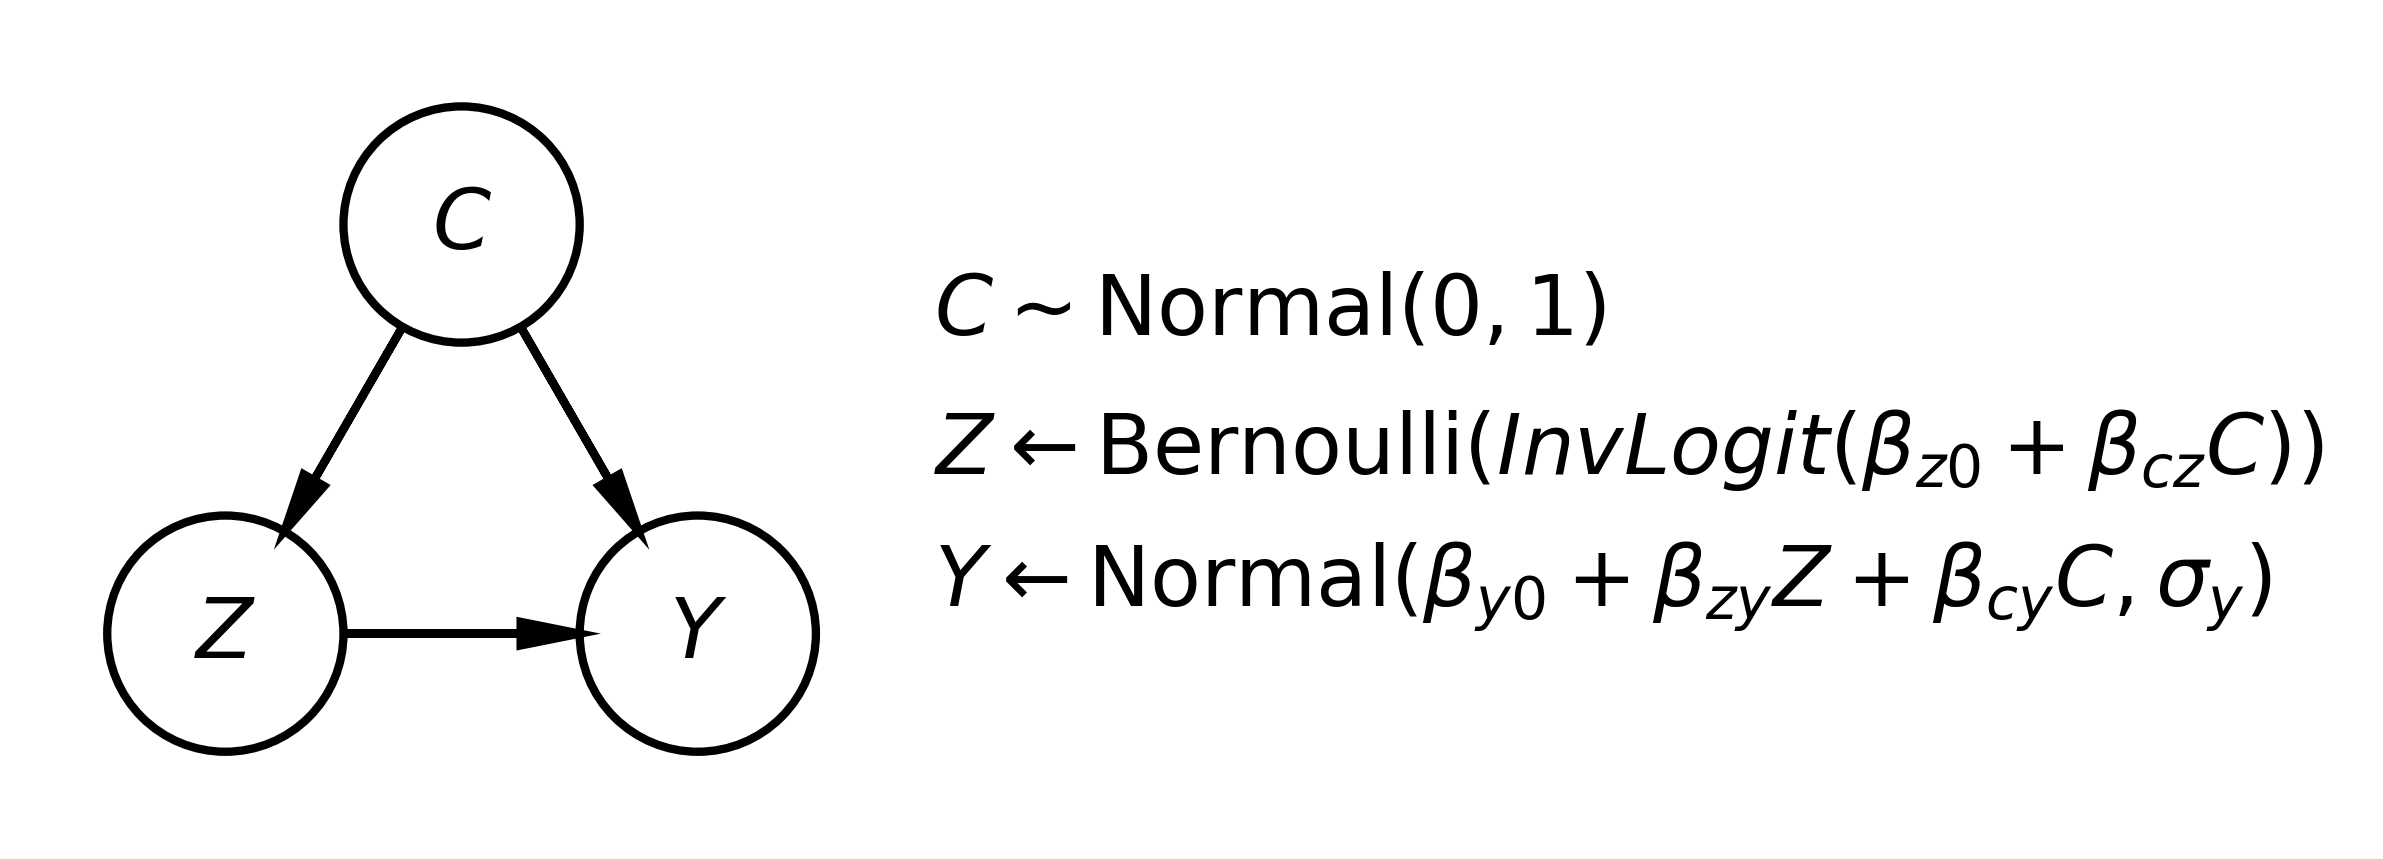

In [12]:
pgm = daft.PGM()
pgm.add_node("y", "$Y$", 0, 0)
pgm.add_node("z", "$Z$", -1, 0)
pgm.add_node("c", "$C$", -0.5, 0.866)
pgm.add_edge("z", "y")
pgm.add_edge("c", "y")
pgm.add_edge("c", "z")
pgm.add_text(0.5, 0.6, r"$C \sim \mathrm{Normal}(0, 1)$")
pgm.add_text(0.5, 0.3, r"$Z \leftarrow \mathrm{Bernoulli}(InvLogit(\beta_{z0} + \beta_{cz} C))$")
pgm.add_text(0.5, 0, r"$Y \leftarrow \mathrm{Normal}(\beta_{y0} + \beta_{zy} Z + \beta_{cy} C, \sigma_y)$")
pgm.render(dpi=300);

# TODO: Explain our causal and inferential goals with this example

To make life a bit simpler, let's define some terminology:
* We have random variables $C$, $Z$, and $Y$
* These are different from observations, specific values, $c$, $z$, and $y$
* We have a set of latent parameters, $\theta = \{ \beta_{z0}, \beta_{y0}, \beta_{zy}, \beta_{zy}, \beta_{cz}, \sigma_{y} \}$

### Define the full data generating process in a PyMC model

At the moment we have to pre-define the number of observations we are dealing with, here it will be `N=100`.

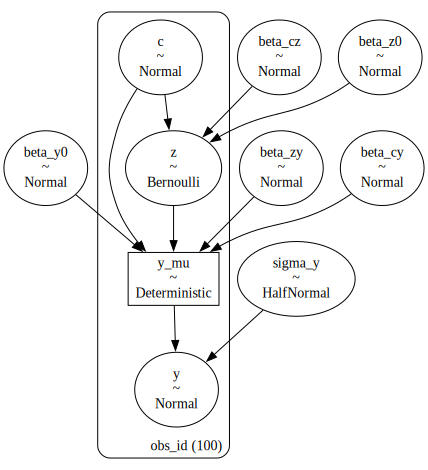

In [13]:
N = 100

coords = {'obs_id': np.arange(N)}

with pm.Model(coords=coords) as model_generative:
    # priors on y <- c -> z
    beta_y0 = pm.Normal("beta_y0")
    beta_cy = pm.Normal("beta_cy")
    beta_cz = pm.Normal("beta_cz")
    # priors on z -> y causal path
    beta_z0 = pm.Normal("beta_z0")
    beta_zy = pm.Normal("beta_zy")
    # observation noise on y
    sigma_y = pm.HalfNormal("sigma_y")
    # core nodes and causal relationships
    c = pm.Normal("c", mu=0, sigma=1, dims='obs_id')
    z = pm.Bernoulli("z", p=pm.invlogit(beta_z0 + beta_cz * c), dims='obs_id')
    y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_zy * z) + (beta_cy * c), dims='obs_id')
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, dims='obs_id')
        
    
pm.model_to_graphviz(model_generative)

### Simulate data by condition upon true parameter values and sampling

Having defined the full joint distribution, we are going to use it to generate simulated data. In order to do that, we are going to specify some true parameter values that govern the causal relationships between nodes.  So let's do that and use the `observe` function to generate a new model - when we plot that we can see that the parameters are now observed nodes.

# ERROR? Nodes are showing as shaded, but still as RV's, not data nodes

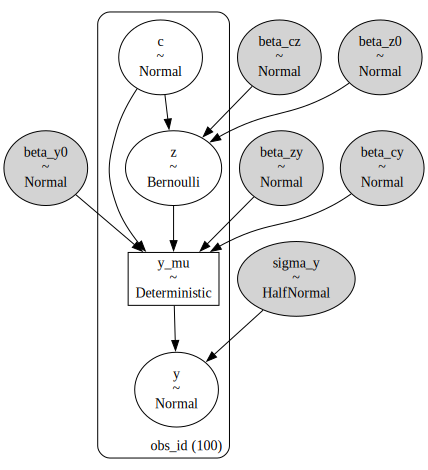

In [14]:
true_ATE = 1

true_values = {"beta_z0": 0, 
               "beta_y0": 0, 
               "beta_cz": 1.5, 
               "beta_zy": true_ATE, 
               "beta_cy": 1, 
               "sigma_y": 0.2}

model_simulate = observe(model_generative, true_values)

pm.model_to_graphviz(model_simulate)

Next, we'll sample from this new model to obtain samples from distibution $P(C, Z, Y | \theta)$.

# ERROR: How do I sample, conditional upon the observed parameters. It should look like this

![](temp.png)

Sampling: [beta_cy, beta_cz, beta_y0, beta_z0, beta_zy, c, sigma_y, y, z]


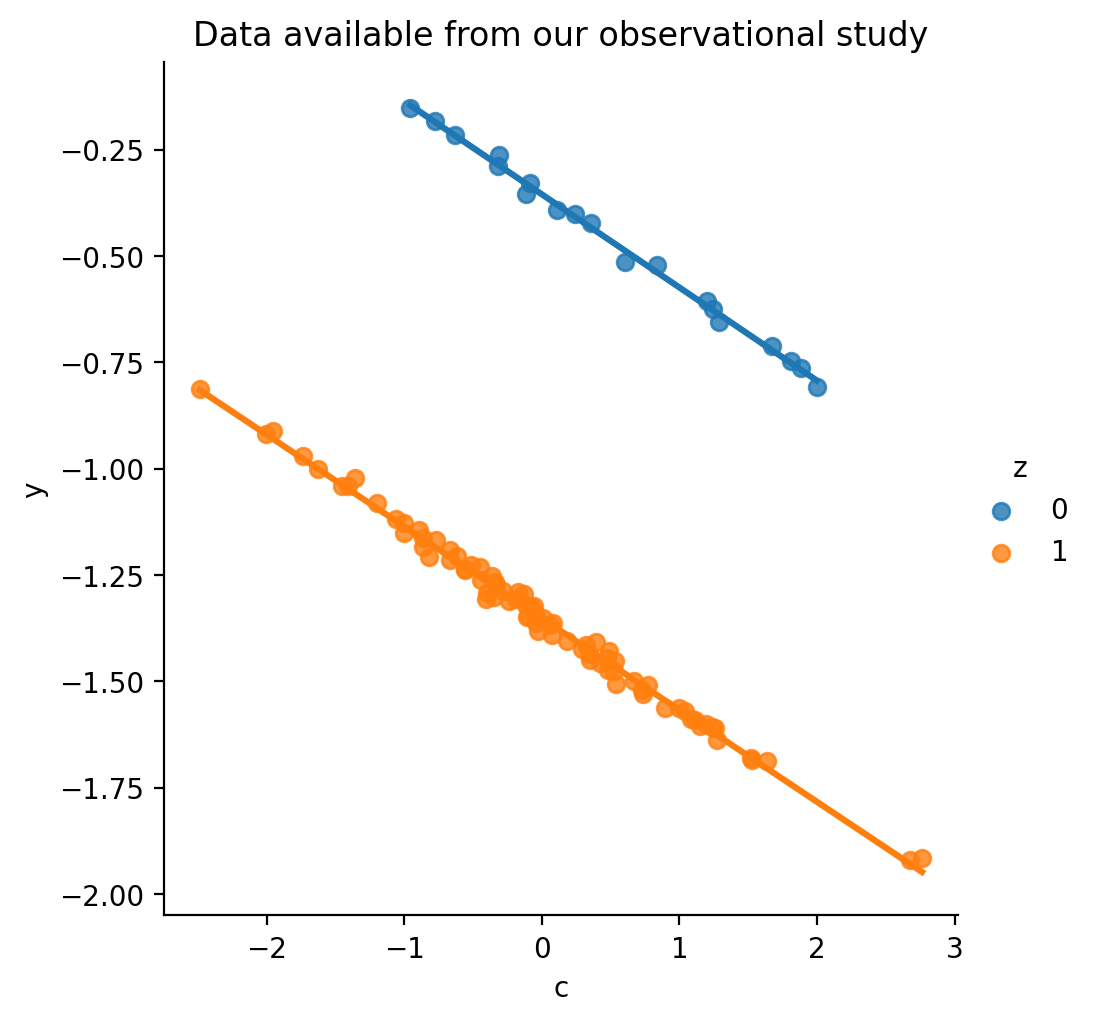

In [15]:
with model_simulate:
    simulate = pm.sample_prior_predictive(samples=1)
    
observed = {"c": simulate.prior['c'].values.flatten(), 
            "y": simulate.prior['y'].values.flatten(),
            "z": simulate.prior['z'].values.flatten()}

df = pd.DataFrame(observed)
ax = sns.lmplot(df[["c", "z", "y"]], x="c", y="y", hue="z")
ax.set(title="Data available from our observational study");

# ERROR: I know I'm asking for samples of the prior distribution, but I hoped that after using `observe` then that would be conditional upon the observed parameter values.

### Inference, $P( \theta | c, z, y)$

Here, we'll revert back to our generative model (where nothing is observed) and now use the `observe` function to inject data into the $c$, $z$, and $y$ nodes. This puts us in the real-world situation of having observed data but not knowing what the parameters of the model that describe the causal relationships.

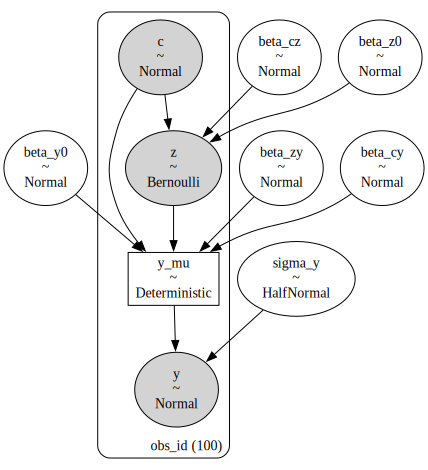

In [16]:
model_inference = observe(model_generative, {"c": observed['c'], "y": observed['y'], "z": observed['z']})
pm.model_to_graphviz(model_inference)

Now we can press the Inference Button and sample from our posterior.

In [17]:
with model_inference:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_y0, beta_cy, beta_cz, beta_z0, beta_zy, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


We can inspect our posterior distributions easily using `arviz`.

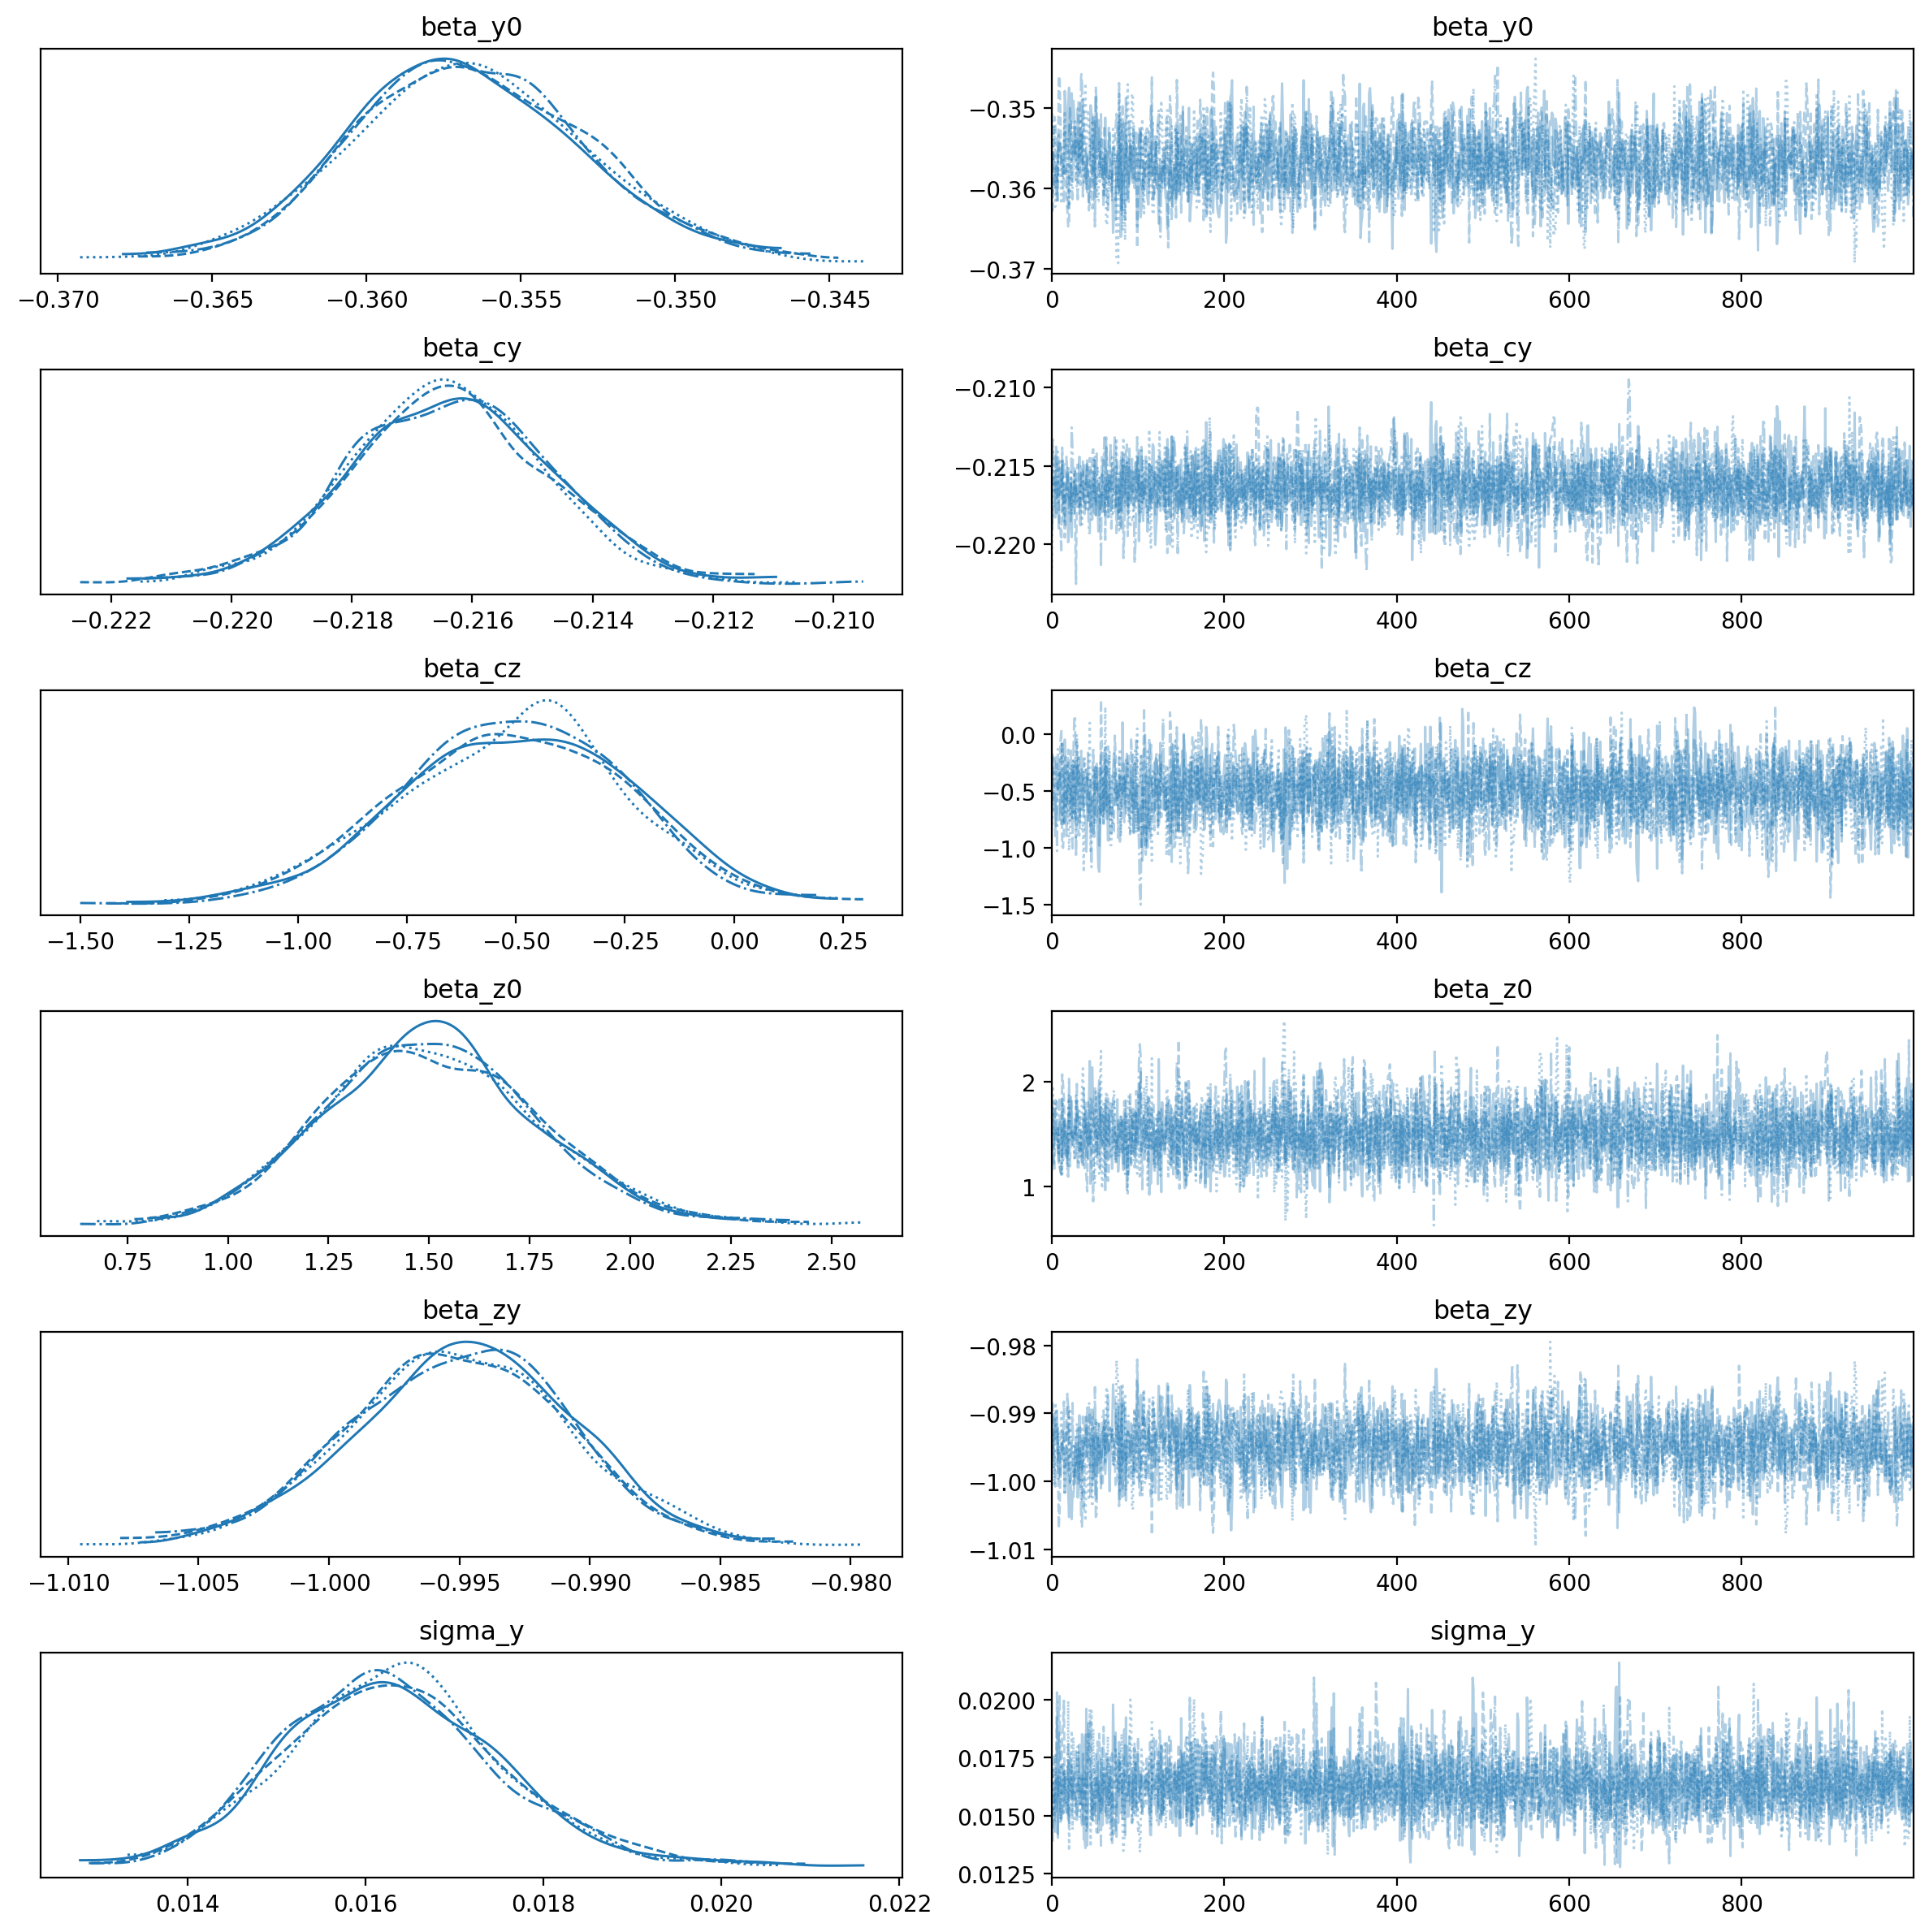

In [18]:
az.plot_trace(idata, var_names="~y_mu")
plt.tight_layout()

### Counterfactuals

# TODO: Gut feeling is that we want a separate blog post on the difference between intervention and counterfactuals and how PyMC can do those. So just give a light-touch explanation here

# TODO: Explain the ATE here and what exactly we are doing

In [19]:
# P(Y | c, do(z=0))
model_control = do(model_inference, {"z": np.zeros(N, dtype='int32')}, prune_vars=True)
with model_control:
    idata_z0 = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_mu"])

# P(Y | c, do(z=1))
model_treat = do(model_inference, {"z": np.ones(N, dtype='int32')}, prune_vars=True)
with model_treat:
    idata_z1 = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_mu"])

Sampling: [c]


Sampling: [c]


In [20]:
# calculate estimated ITE
ATE_est = idata_z1.predictions - idata_z0.predictions

# ERROR: `c` and `y` reverted back to RV's, not observed?

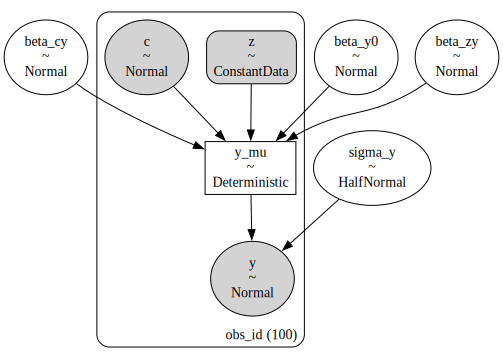

In [21]:
pm.model_to_graphviz(model_control)

In [22]:
def plot_causal_estimates(models, ATE_est, model_names):
    """Utility plot function to generate figure for estimated outcomes and causal effects."""
    fig, ax = plt.subplots(1, 2)
    # left plot of estimated outcomes
    ret = az.plot_forest(
        [models[0].predictions, models[1].predictions],
        combined=True,
        ax=ax[0],
        model_names=model_names,
    )
    # remove alternate row shading
    for p in ret[0].patches:
        p.set_color("white")
    # right plot of estimated ITE
    az.plot_forest(ATE_est, combined=True, ax=ax[1])
    # formatting
    ax[0].set(
        title="Estimated outcomes under intervention",
        ylabel="unit, $i$ (ordered)",
        yticklabels=[],
    )
    ax[1].axvline(true_ATE, color="red", label="true ATE")
    ax[1].legend()
    ax[1].set(
        title=f"Estimated ITE's\nPercentage error = "
        + print_percent_error(ATE_est, true_ATE),
        xlim=(1 - 3, 1 + 3),
        yticklabels=[],
    )
    plt.tight_layout()

In [23]:
def print_percent_error(ATE_est, true_ATE):
    """Utility function to calculate and print the percent error."""
    percent_error = np.abs(ATE_est["y_mu"] - true_ATE) / true_ATE * 100
    hdi = az.hdi(percent_error).sel(obs_id=0)["y_mu"].values
    return f"{percent_error.mean().data:.1f}% ({hdi[0]:.1f} - {hdi[1]:.1f})"

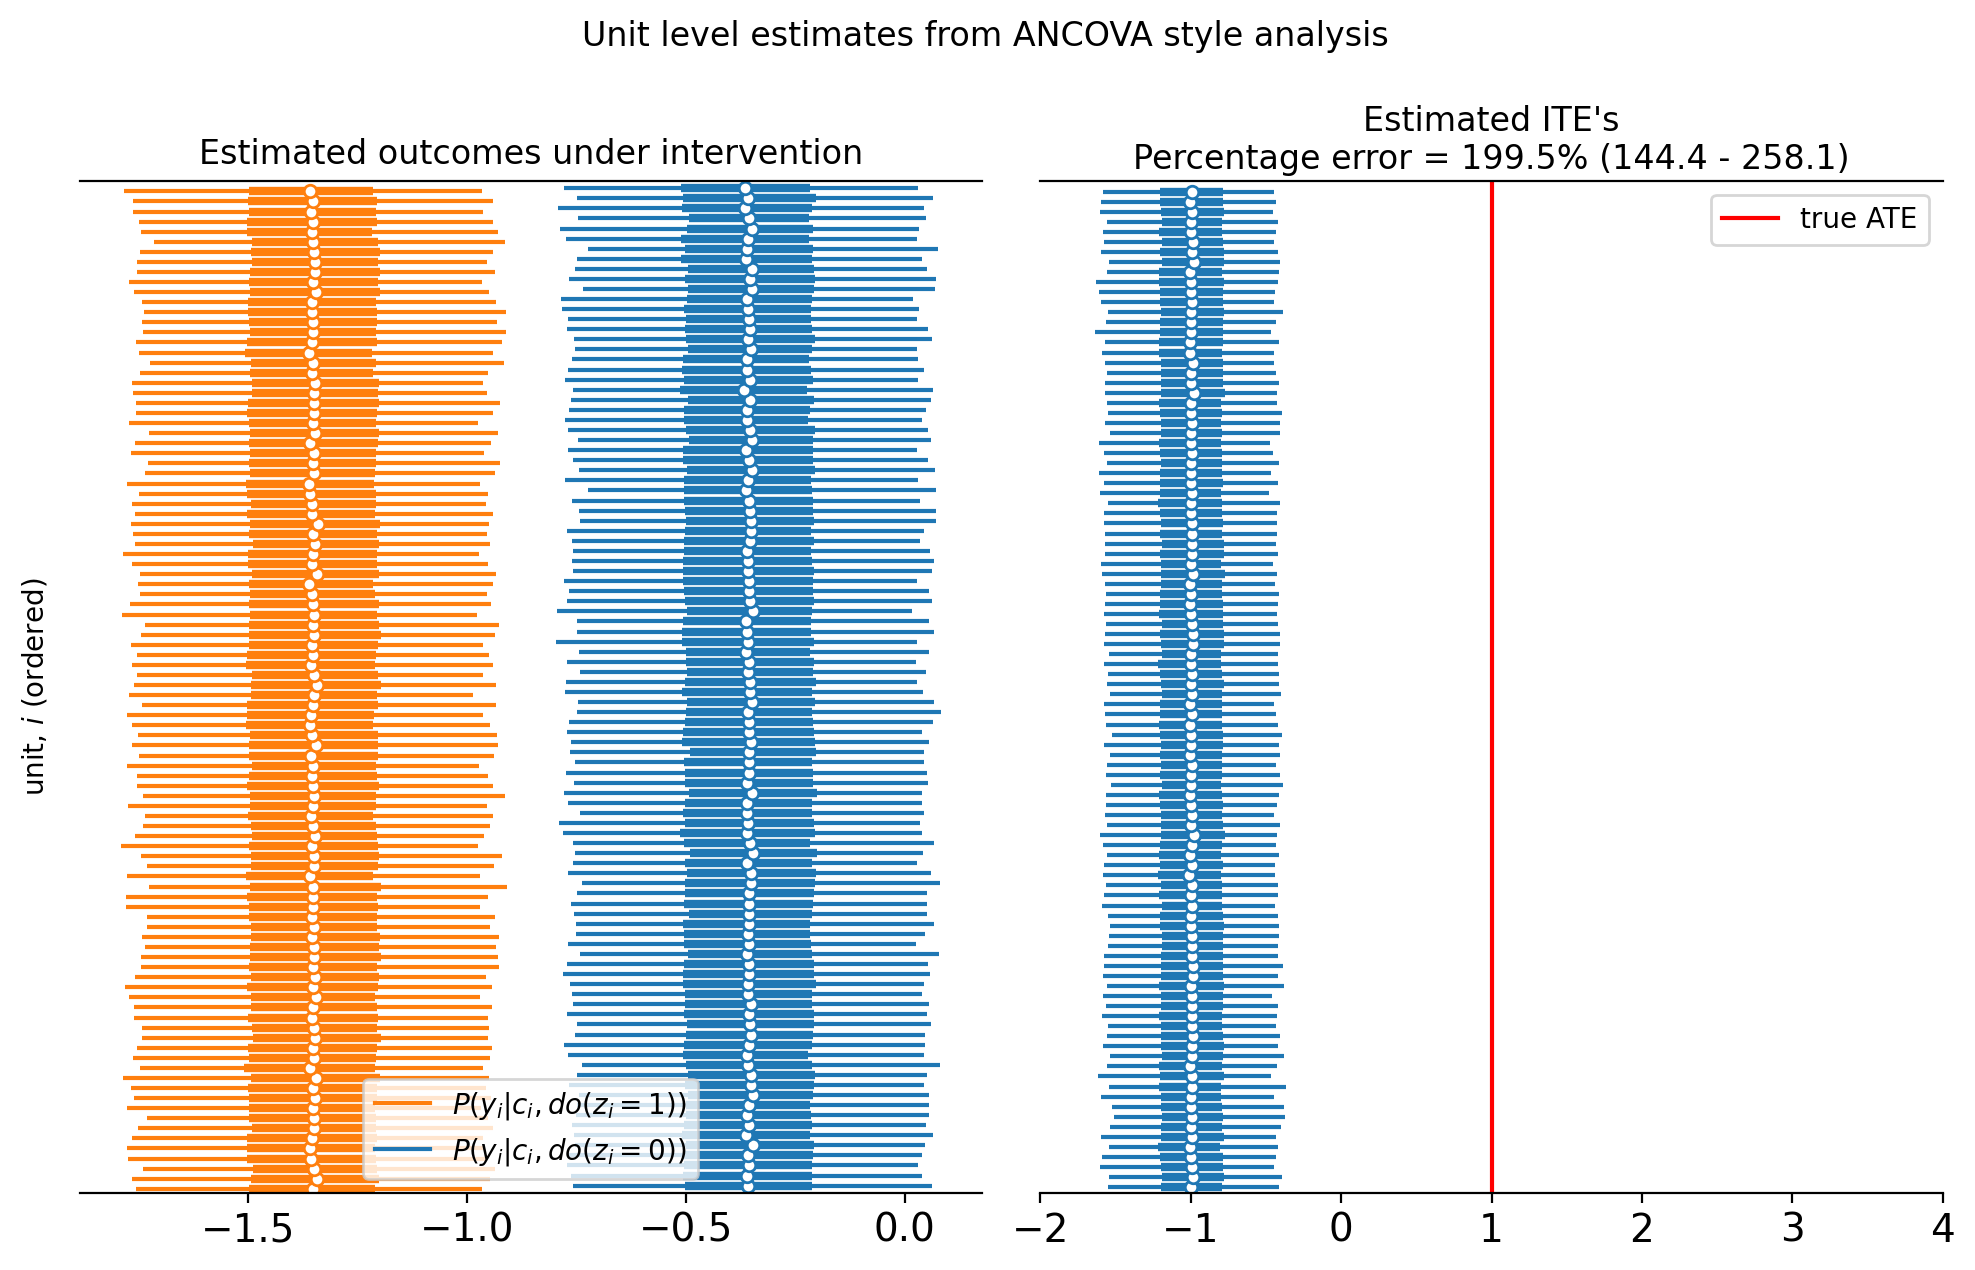

In [24]:
plot_causal_estimates(
    [idata_z0, idata_z1],
    ATE_est,
    model_names=[r"$P(y_i|c_i,do(z_i=0))$", r"$P(y_i|c_i,do(z_i=1))$"],
)
plt.suptitle("Unit level estimates from ANCOVA style analysis", y=1.05);

# ERROR: Because of the above errors, this plot is wrong. We should see different estimates for each unit in the left plot, because they have unique values of the confounding variable

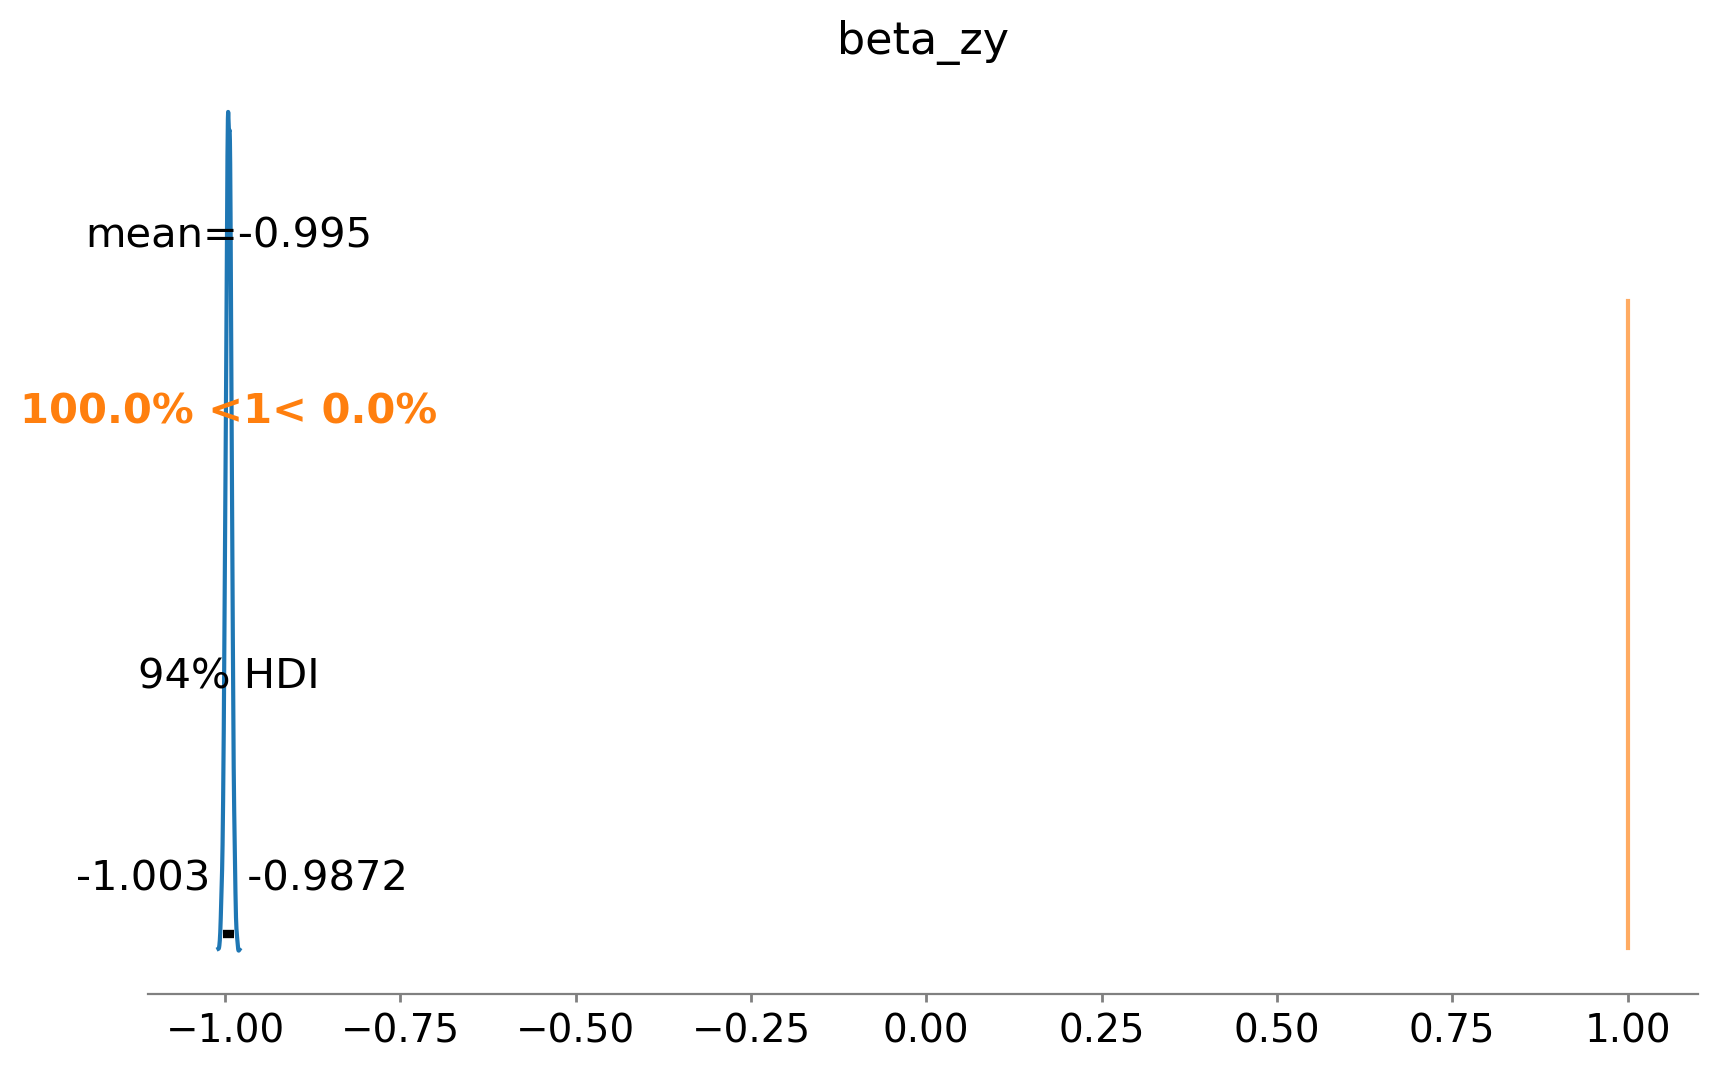

In [25]:
az.plot_posterior(idata, var_names="beta_zy", ref_val=true_ATE, round_to=4);

# TODO - finish the blogpost